# Building a predictive model - Part I

__`Step 1`__ Import all the needed libraries.

In [173]:
# import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

############################################ FEATURE SELECTION ############################################
#!pip install scipy
import scipy.stats as stats
from scipy.stats import chi2_contingency # filter method
from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LogisticRegression #(This is one possible model to apply inside RFE)
from sklearn.linear_model import LassoCV # embedded method
from sklearn.tree import DecisionTreeClassifier # embedded method

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="1st-bullet">

# 1. Import data (Data Integration)

</a>

__`Step 2`__ Import the train dataset and define the index as the `EmployeeNumber`.

In [174]:
df = pd.read_csv('HR_DS.csv')
df.set_index('EmployeeNumber', inplace=True)
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,...,4,80,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,4,...,3,80,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,3,...,3,80,1,17,3,3,5,2,0,3
2062,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,4,...,1,80,1,9,5,3,7,7,1,7
2064,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2,...,2,80,1,6,0,3,6,2,0,3


In [175]:
from sklearn.model_selection import StratifiedKFold

In [176]:
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

In [177]:
X = df.drop('Attrition', axis = 1)
y = df['Attrition'].copy()

In [179]:
def apply_chisquare(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [180]:
def select_best_cat_features(X,y):
    count = 1
    
    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        
        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using chi-square
        X_train_cat = X_train[['BusinessTravel','Department','EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)
            
        count+=1

In [181]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
BusinessTravel is IMPORTANT for Prediction
Department is IMPORTANT for Prediction
EducationField is IMPORTANT for Prediction
Gender is NOT an important predictor. (Discard Gender from model)
JobRole is IMPORTANT for Prediction
MaritalStatus is IMPORTANT for Prediction
Over18 is NOT an important predictor. (Discard Over18 from model)
OverTime is IMPORTANT for Prediction
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
BusinessTravel is IMPORTANT for Prediction
Department is IMPORTANT for P

#### What can we conclude?

| Predictor | Chi-Square | What to do? (One possible way to "solve")|
| --- | --- | --- |
| BusinessTravel | 5 YES | Keep |
| Department | 5 YES | Keep |
| OverTime | 5 YES | Keep |
| JobRole | 5 YES | Keep |
| MaritalStatus | 5 YES | Keep |
| EducationField | 4 YES & 1 NO |Remove|
| Gender | 5 NO |Remove|
| Over18 | 5 NO |Remove|

In [182]:
X = X.drop(['EducationField','Gender', 'Over18'], axis = 1)

In [183]:
def apply_variance(X_train):
    X_train_numeric = X_train.select_dtypes(include=['number'])
    print(X_train_numeric.var())

In [184]:
def select_features_variance(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using variance
        apply_variance(X_train)
            
        count+=1

In [185]:
select_features_variance(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Age                         8.542577e+01
DailyRate                   1.630649e+05
DistanceFromHome            6.529640e+01
Education                   1.050976e+00
EmployeeCount               0.000000e+00
EnvironmentSatisfaction     1.219349e+00
HourlyRate                  4.076624e+02
JobInvolvement              5.056680e-01
JobLevel                    1.268768e+00
JobSatisfaction             1.201251e+00
MonthlyIncome               2.303965e+07
MonthlyRate                 5.080834e+07
NumCompaniesWorked          6.148617e+00
PercentSalaryHike           1.323087e+01
PerformanceRating           1.243704e-01
RelationshipSatisfaction    1.149805e+00
StandardHours               0.000000e+00
StockOptionLevel         

#### What can we conclude?

- `EmployeeCount` and `StandardHours` are constant features. We should remove those.

In [186]:
X = X.drop(['EmployeeCount', 'StandardHours'], axis = 1)

In [187]:
def cor_heatmap(cor):
    plt.figure(figsize=(10,6))
    sns.heatmap(data = cor, annot = True, fmt=".1f", cmap = plt.cm.Reds, annot_kws={"size": 8})
    plt.show()

In [188]:
def apply_correlation(X_train):
    correlation_data = X_train.select_dtypes(include=['number'])
    matrix = correlation_data.corr(method = 'spearman')
    cor_heatmap(matrix)

In [189]:
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # check which features to use using spearman correlation
        apply_correlation(X_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


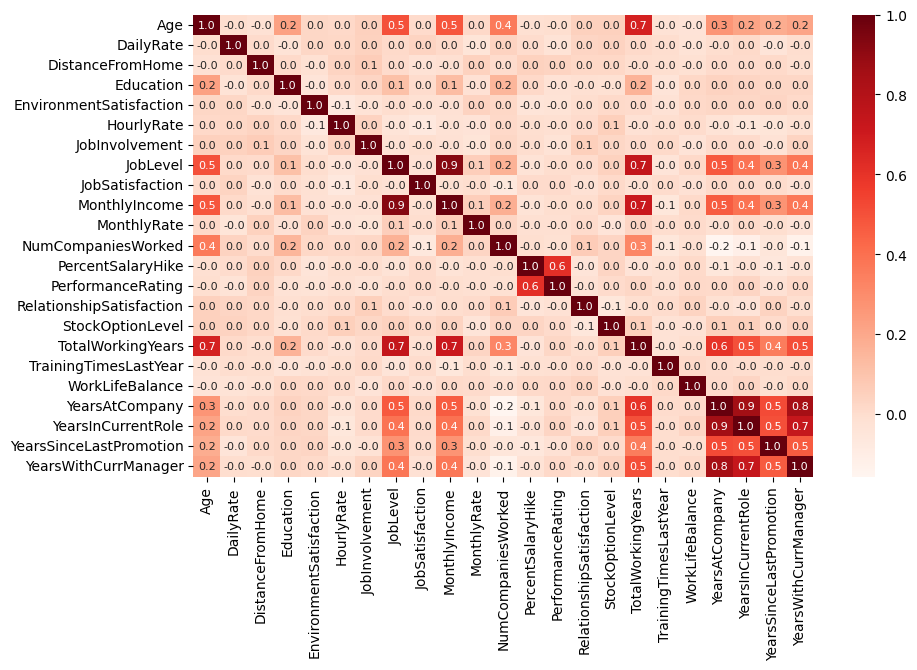

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


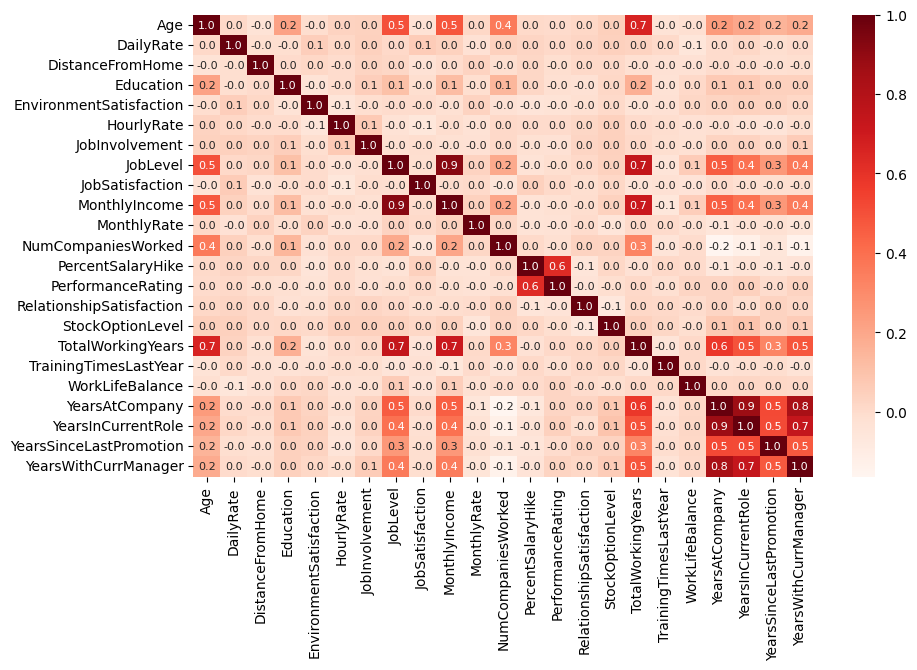

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


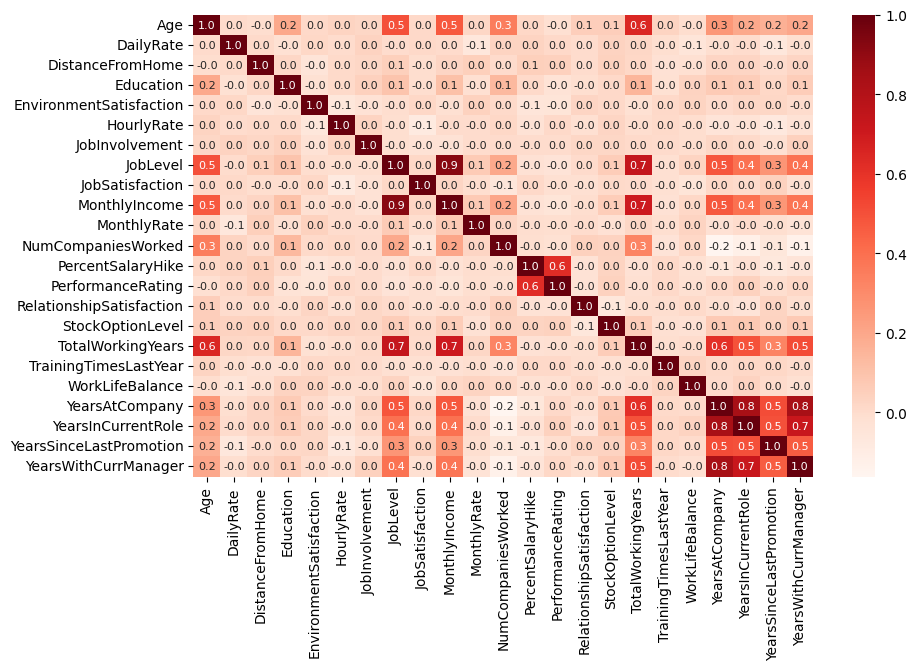

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


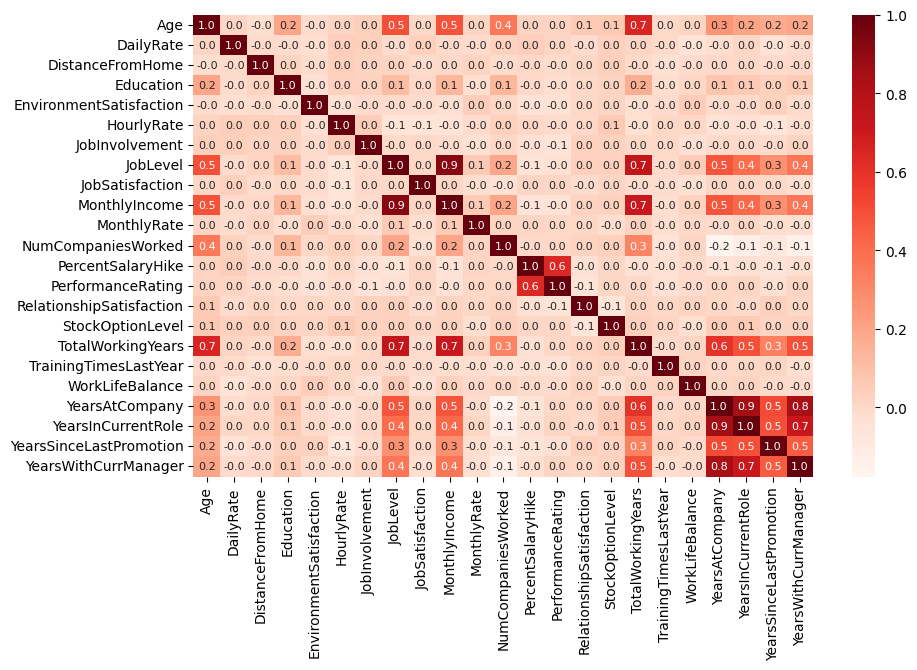

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


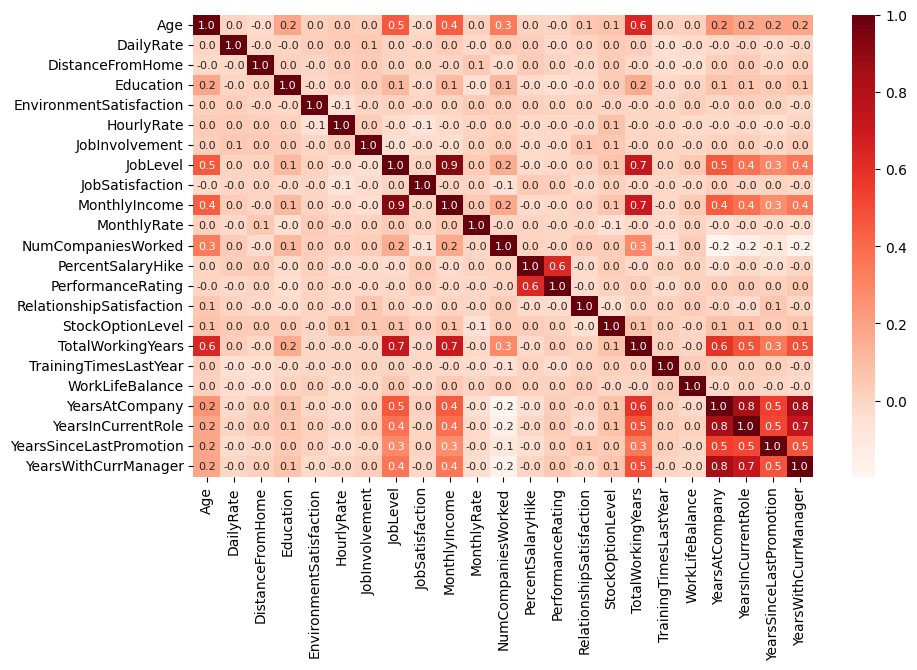

In [190]:
redundant_features(X, y)

### Redundant Variables - Spearman Correlation (Correlation higher than |0.8|)

| Combination | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
| --- | --- | --- | --- | --- | --- |
| MonthlyIncome VS JobLevel | 0.9 | 0.9 | 0.9 | 0.9 | 0.9 |
| YearsInCurrentRole VS YearsAtCompany | 0.9 | 0.9 | 0.8 | 0.9 | 0.8 |
| YearWithCurrManager VS YearsAtCompany | 0.8 | 0.8 | 0.8 | 0.8 | 0.8 |


In this case, we can see that there are high correlations within two groups of variables:
- MonthlyIncome and JobLevel
- YearsAtCompany, YearsInCurrentRole, YearWithCurrManager

Now it is time to understand the ones that we should keep and the ones to be removed. <br>

The remaining methods that we are going to apply  for feature selection are: 
- __Wrapper methods__ - RFE
- __Embedded Methods__ - Lasso Regression and Decision Trees

It is important to note that regression models are particularly sensible to correlated features. Therefore, we will begin by applying decision trees to identify which features among the correlated ones should be excluded. 

Once we have eliminated the correlated features, we can proceed with techniques that involve regression models, such as RFE (using Logistic Regression) and Lasso Regression.

In [191]:
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [192]:
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns)
    plot_importance(feature_importances, 'DT')

In [193]:
def select_best_features_dt(X, y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using decision Tree
        X_train = X_train.drop(['BusinessTravel','Department','OverTime', 'JobRole', 'MaritalStatus'], axis = 1)
        apply_dt(X_train, y_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


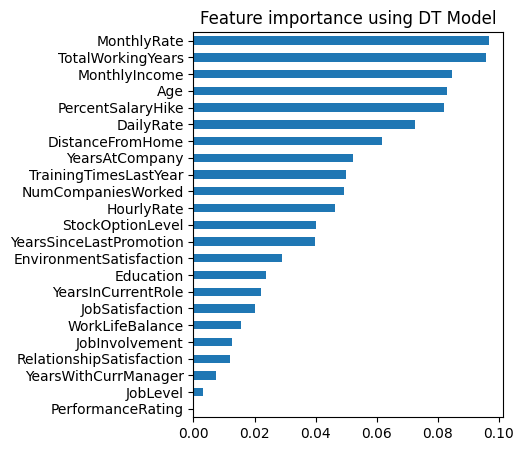

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


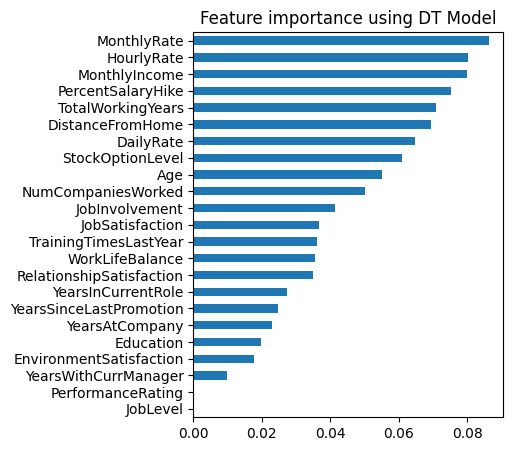

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


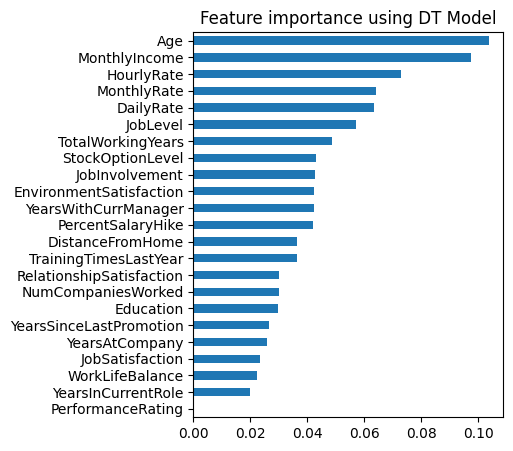

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


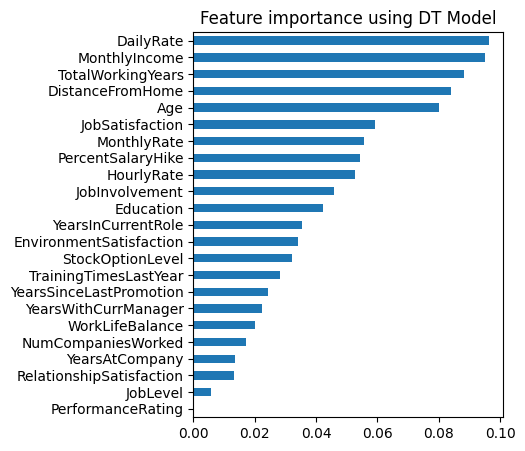

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


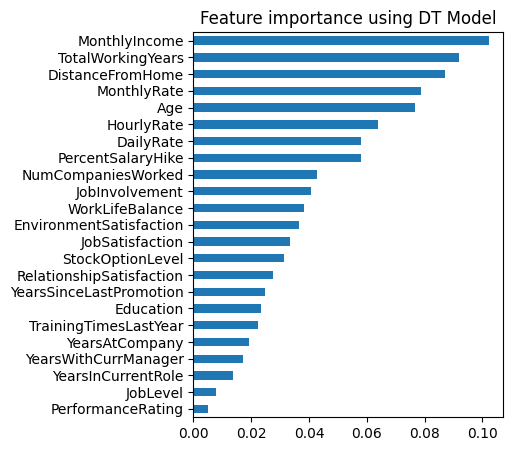

In [194]:
select_best_features_dt(X, y)

JobLevel

YearsInCurrentRole
YearsWithCurrManager

In [195]:
X = X.drop(['JobLevel','YearsInCurrentRole','YearsWithCurrManager'], axis = 1)

In [196]:
X.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsSinceLastPromotion'],
      dtype='object')

In [163]:
X.dtypes

Age                          int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EnvironmentSatisfaction      int64
HourlyRate                   int64
JobInvolvement               int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
dtype: object

In [197]:
X['OverTime'].value_counts()

OverTime
No     1054
Yes     416
Name: count, dtype: int64

In [201]:
y.describe()

count     1470
unique       2
top         No
freq      1233
Name: Attrition, dtype: object

In [202]:
y = y.map({'Yes': 1, 'No': 0})

In [204]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)

In [205]:
def apply_lasso(X_train, y_train):
    lasso = LassoCV().fit(X_train, y_train)
    coef = pd.Series(lasso.coef_, index = X_train.columns)
    plot_importance(coef,'Lasso')

In [209]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        numerical_data = X_train.drop(['BusinessTravel','Department','JobRole', 'MaritalStatus', 'OverTime'], axis = 1).copy()
        scaler = MinMaxScaler().fit(numerical_data)
        X_train_scaled = scaler.transform(numerical_data)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_data.columns)
    
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)
        
        # check which features to use using lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train_scaled, y_train)
            
        # check which features to use using lasso
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train_scaled, y_train)
            
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Age                         False
DailyRate                   False
DistanceFromHome            False
Education                   False
EnvironmentSatisfaction     False
HourlyRate                  False
JobInvolvement               True
JobSatisfaction             False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StockOptionLevel             True
TotalWorkingYears            True
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany               True
YearsSinceLastPromotion      T

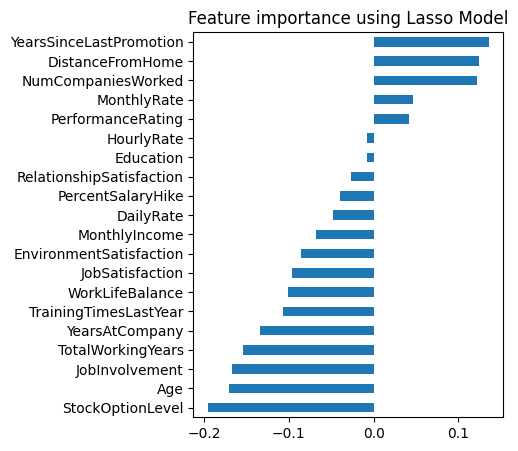


----------------- DT ----------------------


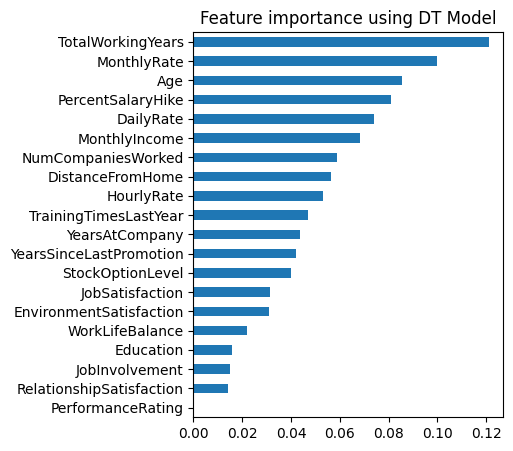

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Age                         False
DailyRate                   False
DistanceFromHome            False
Education                   False
EnvironmentSatisfaction     False
HourlyRate                  False
JobInvolvement               True
JobSatisfaction             False
MonthlyIncome                True
MonthlyRate                 False
NumCompaniesWorked           True
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StockOptionLevel             True
TotalWorkingYears            True
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany              False
YearsSinceLastPromotion     Fa

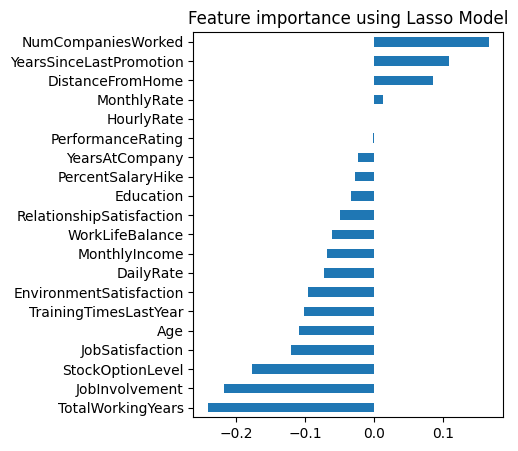


----------------- DT ----------------------


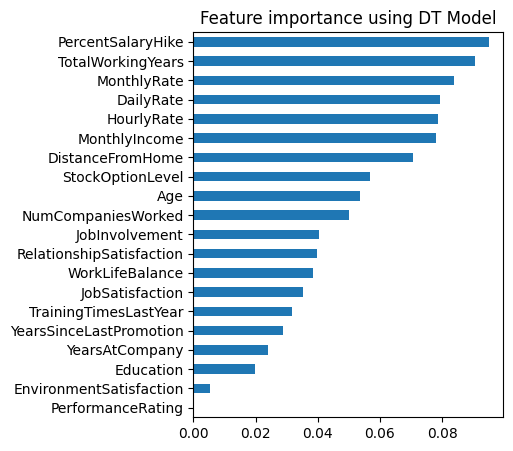

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Age                          True
DailyRate                   False
DistanceFromHome            False
Education                   False
EnvironmentSatisfaction     False
HourlyRate                  False
JobInvolvement               True
JobSatisfaction             False
MonthlyIncome                True
MonthlyRate                 False
NumCompaniesWorked          False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StockOptionLevel             True
TotalWorkingYears            True
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany              False
YearsSinceLastPromotion     Fa

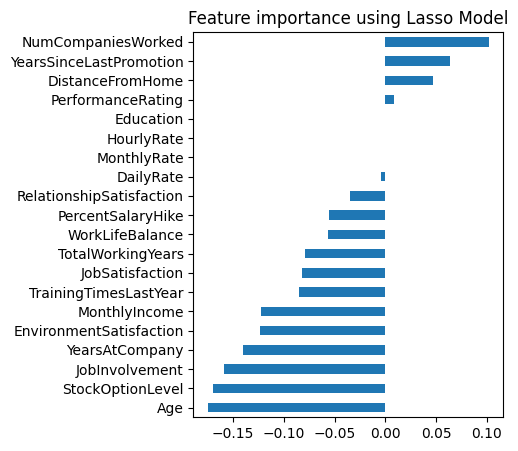


----------------- DT ----------------------


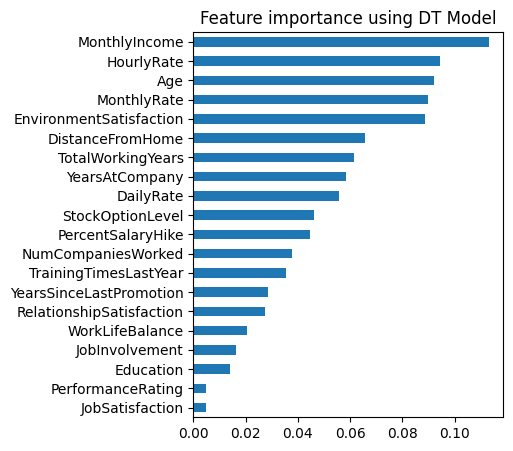

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Age                         False
DailyRate                   False
DistanceFromHome            False
Education                   False
EnvironmentSatisfaction     False
HourlyRate                  False
JobInvolvement               True
JobSatisfaction             False
MonthlyIncome                True
MonthlyRate                 False
NumCompaniesWorked          False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StockOptionLevel             True
TotalWorkingYears            True
TrainingTimesLastYear       False
WorkLifeBalance              True
YearsAtCompany              False
YearsSinceLastPromotion     Fa

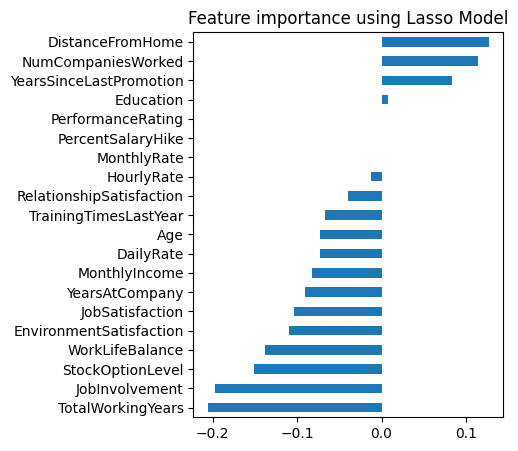


----------------- DT ----------------------


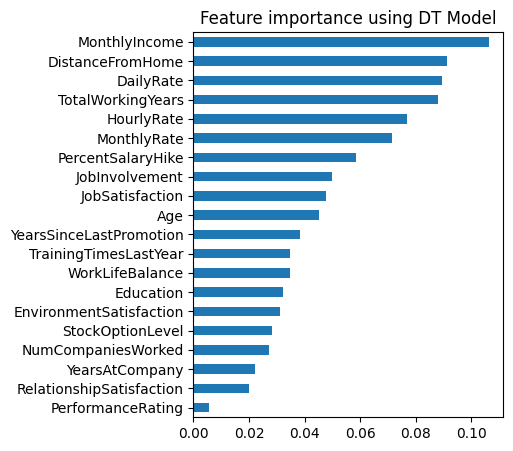

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Age                          True
DailyRate                   False
DistanceFromHome            False
Education                   False
EnvironmentSatisfaction     False
HourlyRate                  False
JobInvolvement               True
JobSatisfaction             False
MonthlyIncome                True
MonthlyRate                 False
NumCompaniesWorked          False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StockOptionLevel             True
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany               True
YearsSinceLastPromotion     Fa

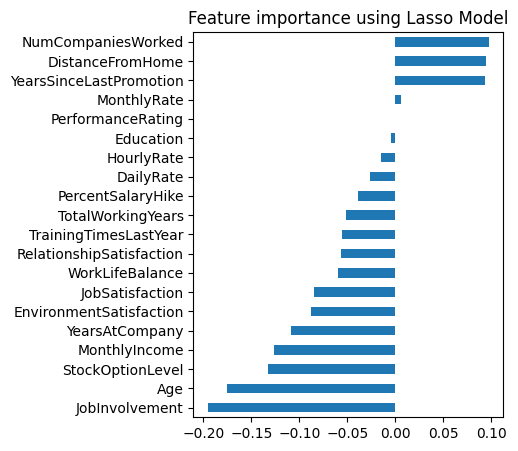


----------------- DT ----------------------


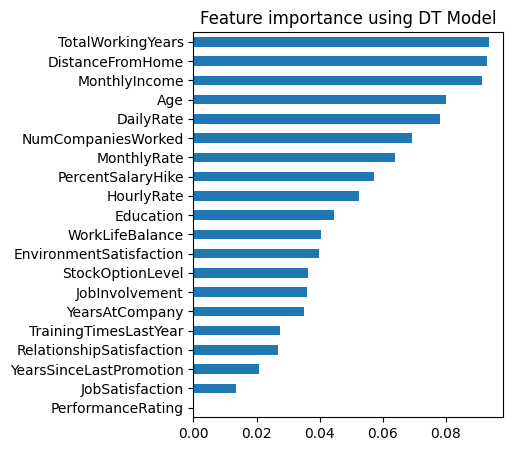

In [210]:
select_best_features(X, y)

At the end, you can combine the results you obtained previously to understand which features are the most important ones. <br>
In Decision Trees and in Lasso, we are going to select the the Top 5.

<hr>



### Numerical Data

`Which variables should we keep using this techniques?`

| Predictor | RFE | Lasso | DT | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- | --- |
Age | 2 YES | 0 YES | 3 YES | |
DailyRate | 0 YES | 0 YES | 4 YES | |
DistanceFromHome | 0 YES | 5 YES | 2 YES |  |
Education | 0 YES | 0 YES | 0 YES |  |
EnvironmentSatisfaction | 0 YES | 0 YES | 1 YES |  |
HourlyRate | 0 YES | 1 YES | 3 YES |  |
JobInvolvement | 5 YES | 0 YES | 0 YES |  |
JobSatisfaction | 0 YES | 0 YES | 0 YES | |
MonthlyIncome | 4 YES | 0 YES | 3 YES |  |
MonthlyRate | 0 YES | 3 YES | 3 YES |  |
NumCompaniesWorked | 1 YES | 5 YES | 0 YES |  |
PercentSalaryHike | 0 YES | 0 YES | 2 YES |  |
PerformanceRating | 0 YES | 4 YES | 0 YES |  |
RelationshipSatisfaction | 0 YES | 0 YES | 0 YES |  |
StockOptionLevel | 5 YES | 0 YES | 0 YES |  |
TotalWorkingYears | 4 YES | 0 YES | 4 YES |  |
TrainingTimesLastYear | 0 YES | 0 YES | 0 YES |  |
WorkLifeBalance | 1 YES | 0 YES | 0 YES |  |
YearsAtCompany | 2 YES | 0 YES | 0 YES |  |
YearsSinceLastPromotion | 1 YES | 5 YES | 0 YES |  |


Based on the total scores, the top 5 features would be:

TotalWorkingYears (8)
DistanceFromHome (7)
MonthlyIncome (7)
MonthlyRate (6)
NumCompaniesWorked (6)
<hr>

In [212]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [214]:
keep_data = df[['TotalWorkingYears','DistanceFromHome','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 'OverTime', 'BusinessTravel', 'MaritalStatus', 'JobRole', 'Department', 'Attrition']].copy()

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

############################################## PREPROCESSING ##############################################
from sklearn.preprocessing import MinMaxScaler

################################################# MODELS ##################################################
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

################################################# METRICS #################################################
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

################################### MODEL SELECTION & OPTIMIZATION ########################################
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

######################################### DECISION TREES PLOTS ############################################
# in anaconda prompt: conda install python-graphviz
#!pip install pydotplus
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

In [267]:
df = df.replace({'No': 0, 'Yes': 1})

In [266]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,...,4,80,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,4,...,3,80,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,3,...,3,80,1,17,3,3,5,2,0,3
2062,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,4,...,1,80,1,9,5,3,7,7,1,7
2064,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2,...,2,80,1,6,0,3,6,2,0,3


In [247]:
def transform_data(X_train, X_2nd_df = False, X_2nd_df_flag = False):
    
    ########################################## CREATE DUMMIES #################################################    
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    X_train_dummies = pd.get_dummies(X_train)
   
    ############################################ SCALE DATA ###################################################    
    scaler = MinMaxScaler().fit(X_train_dummies)
    X_train_scaled = scaler.transform(X_train_dummies)
    X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train_dummies.columns)
    
    if X_2nd_df_flag == True:
        # Create dummies for X_2nd_df
        X_2nd_df_dummies = pd.get_dummies(X_2nd_df)  # This line was missing
        # If we don't have all the values in the validation dataset that we have in the train, that column will not be created
        # We should assure that all columns in train are also present in validation
        # Get missing columns from the training dataset
        missing_cols = set(X_train_dummies.columns ) - set(X_2nd_df_dummies.columns )
        # Add a missing column in test set with default value equal to 0
        for c in missing_cols:
            X_2nd_df_dummies[c] = 0
        # Ensure the order of column in the test set is in the same order than in train set
        X_2nd_df_dummies = X_2nd_df_dummies[X_train_dummies.columns]
        
        if 'Attrition' in X_2nd_df_dummies.columns:
            X_2nd_df_dummies.drop(['Attrition'], axis=1, inplace=True)
        else:
            pass
        
        ############################################ SCALE DATA ###################################################    
        X_2nd_df_scaled = scaler.transform(X_2nd_df_dummies) # Scaling with 'scaler' from train data
        X_2nd_df_scaled = pd.DataFrame(X_2nd_df_scaled , columns = X_2nd_df_dummies.columns, index = X_2nd_df_dummies.index )
        
   
    if X_2nd_df_flag == False:
        return X_train_scaled
    else:
        return X_train_scaled, X_2nd_df_scaled

In [248]:
def transform_data(X_train, X_2nd_df = False, X_2nd_df_flag = False):
    
    ########################################## CREATE DUMMIES #################################################    
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    X_train_dummies = pd.get_dummies(X_train)
   
    ############################################ SCALE DATA ###################################################    
    scaler = MinMaxScaler().fit(X_train_dummies)
    X_train_scaled = scaler.transform(X_train_dummies)
    X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train_dummies.columns)
    
    if X_2nd_df_flag == True:
        
        # Create dummies for X_2nd_df
        X_2nd_df_dummies = pd.get_dummies(X_2nd_df)  # This line was missing
        
        # If we don't have all the values in the validation dataset that we have in the train, that column will not be created
        # We should assure that all columns in train are also present in validation
        # Get missing columns from the training dataset
        missing_cols = set(X_train_dummies.columns ) - set(X_2nd_df_dummies.columns )
        # Add a missing column in test set with default value equal to 0
        for c in missing_cols:
            X_2nd_df_dummies[c] = 0
        # Ensure the order of column in the test set is in the same order than in train set
        X_2nd_df_dummies = X_2nd_df_dummies[X_train_dummies.columns]
        
        if 'Attrition' in X_2nd_df_dummies.columns:
            X_2nd_df_dummies.drop(['Attrition'], axis=1, inplace=True)
        else:
            pass
        
        ############################################ SCALE DATA ###################################################    
        X_2nd_df_scaled = scaler.transform(X_2nd_df_dummies) # Scaling with 'scaler' from train data
        X_2nd_df_scaled = pd.DataFrame(X_2nd_df_scaled , columns = X_2nd_df_dummies.columns, index = X_2nd_df_dummies.index )
        
   
    if X_2nd_df_flag == False:
        return X_train_scaled
    else:
        return X_train_scaled, X_2nd_df_scaled

In [249]:
def select_best_models(data, model):
    skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)
    X = data.drop('Attrition', axis = 1)
    y = data['Attrition'].copy()
    score_train, score_val = [],[]
        
    # perform the cross-validation    
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Change categorical data - call function "transform_data"
        X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag = True)
        
        # Apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

In [250]:
def show_results(df, data, *args):
    count = 0
    # for each instance of model passed as argument
    for arg in args:
        avg_train, std_train, avg_val, std_val = select_best_models(data, arg)
        # store the results in the right row
        df.iloc[count] = str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val)
        count+=1
    return df

In [286]:
model_LR = LogisticRegression()
model_DT = DecisionTreeClassifier(max_depth = 3, random_state = 99)
model_NN = MLPClassifier(max_iter = 2000, random_state = 99)

In [278]:
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','DT','NN'])

In [280]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [281]:
df.drop(columns=["EmployeeCount"], inplace=True) 
df.drop(columns=["StandardHours"], inplace=True)
df.drop(columns=["Over18"], inplace=True)

KeyError: "['EmployeeCount'] not found in axis"

In [288]:
show_results(df_all, df, model_LR, model_DT, model_NN)

,Train,Validation
Logistic Regression,0.581+/-0.02,0.497+/-0.08
DT,0.326+/-0.07,0.205+/-0.09
NN,1.0+/-0.0,0.453+/-0.06


In [260]:
def point_plot(train, validation, values_try):
    sns.pointplot(x=values_try, y=train, color = 'teal', label = 'Train')
    sns.pointplot(x=values_try, y=validation, color = 'goldenrod', label = 'Validation')
    plt.legend()

In [284]:
def get_models_dt(data, values):
    models = dict()
    results_train, results_val = [],[]
    
    # create the instances of each model with different values
    for value in values:
        models['depth_' + str(value)] = DecisionTreeClassifier(max_depth = value, random_state = 99)
        
    for name, model in models.items():
        avg_train, std_train, avg_val, std_val = select_best_models(data, model)
        results_train.append(avg_train)
        results_val.append(avg_val)
        
    return results_train, results_val

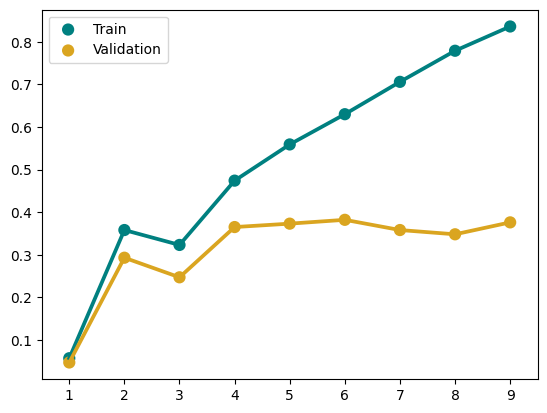

In [285]:
values_try = [1,2,3,4,5,6,7,8,9]
results_train, results_val = get_models_dt(keep_data, values_try)
point_plot(results_train, results_val, values_try)

In [263]:
final_model_dt = DecisionTreeClassifier(max_depth = 2, random_state = 99)

In [265]:
df_final_models = pd.DataFrame(columns = ['Train','Validation'], index = ['Best DT'])
show_results(df_final_models, keep_data, final_model_dt)

,Train,Validation
Best DT,0.358+/-0.06,0.293+/-0.05
